# Examples reservoir models
*Mark Bakker, Delft University of Technology*

**Warning:** 
This is a proof-of-concept of the Reservoir model. The Reservoir model is still under development and not yet meant for general application. No noise model has been used in the models presented in this notebook. This might lead to wrong estimates of the parameter uncertainties.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
import pastas as ps
ps.show_versions()

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.21.2
Scipy version: 1.7.3
Pandas version: 1.3.5
Pastas version: 0.20.0b
Matplotlib version: 3.5.0


## Single reservoir model as compared to exponential response function

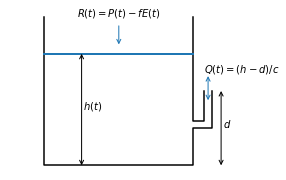

In [2]:
def arrow(xystart, xyend, text="", arrow="<-", color='k', **kwds):
    plt.annotate(text,
                 xy=xystart, 
                 xytext=xyend, 
                 arrowprops=dict(arrowstyle=arrow, shrinkA=0, shrinkB=0, color=color),
                 color=color,
                 **kwds)

plt.figure(figsize=(4, 5))
plt.subplot(111, aspect=1)
plt.plot([0.2, 0.2, 1, 1, 1.1, 1.1], [0.8, 0, 0, 0.2, 0.2, 0.4], 'k')
plt.plot([1.06, 1.06, 1, 1], [0.4, 0.24, 0.24, 0.8], 'k' )
plt.plot([0.2, 1], [0.6, 0.6], 'C0', lw=2)
arrow((1.08, 0.35), (1.08, 0.48), arrow='<->', color='C0')
plt.text(0.41, 0.3, '$h(t)$')
plt.text(1.06, 0.5, '$Q(t)=(h-d)/c$')
arrow((1.15, 0), (1.15, 0.4), arrow='<->')
plt.text(1.16, 0.2, '$d$')
arrow((0.6, 0.75), (0.6, 0.65), color='C0')
plt.text(0.6, 0.8, '$R(t)=P(t)-fE(t)$', ha='center')
arrow((0.4, 0), (0.4, 0.6), arrow='<->')
plt.xlim(0, 1.2)
plt.axis('off');

\begin{equation}
\frac{\text{d}h}{\text{d}t} = \frac{R}{S} - \frac{h-d}{cS}
\end{equation}

Implicit solution:
\begin{equation}
h_t = \frac{h_{t-\Delta t} + R\Delta t / S + \Delta t / (cS) d}{1 + \Delta t / (cS)}
\end{equation}

In [3]:
hobs = pd.read_csv('../data/head_nb1.csv', parse_dates=['date'],
                     index_col='date', squeeze=True)
prec = pd.read_csv('../data/rain_nb1.csv', parse_dates=['date'],
                     index_col='date', squeeze=True)
evap = pd.read_csv('../data/evap_nb1.csv', parse_dates=['date'],
                   index_col='date', squeeze=True)

In [4]:
ml = ps.Model(hobs, name="reservoirtest", constant=False, noisemodel=False)
rsv = ps.ReservoirModel([prec, evap], ps.reservoir.Reservoir1, 'reservoir', ml.oseries.series.mean())
ml.add_stressmodel(rsv)

INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.


AttributeError: module 'pastas' has no attribute 'reservoir'

In [ ]:
#%timeit ml.solve(noise=False, solver=ps.LmfitSolve, tmin='1995', tmax='2005', report=False)

In [ ]:
ml.solve(noise=False, solver=ps.LmfitSolve, tmin='1995', tmax='2005')
hreservoir = ml.simulate()

### Comparison with exponential response function
\begin{equation}
\theta_{step}=A(1-\text{e}^{-t/a})
\end{equation}
with
\begin{equation}
A = c
\end{equation}
\begin{equation}
a = cS
\end{equation}

In [ ]:
mlbase = ps.Model(hobs)
sm = ps.RechargeModel(prec, evap, ps.Exponential, name='rech')
mlbase.add_stressmodel(sm)

In [ ]:
#%timeit mlbase.solve(solver=ps.LmfitSolve, noise=False, tmin='1995', tmax='2005', report=False)

In [ ]:
mlbase.solve(solver=ps.LmfitSolve, noise=False, tmin='1995', tmax='2005')
hbase = mlbase.simulate()

In [ ]:
hreservoir.plot(label='reservoir')
hbase.plot(ls='--', label='exponential')
plt.legend();

In [ ]:
(hreservoir - hbase).plot();

## Reservoir model with overflow as compared to Tarso

In [ ]:
plt.figure(figsize=(4, 5))
plt.subplot(111, aspect=1)
plt.plot([0.2, 0.2, 1, 1, 1.1, 1.1], [0.8, 0, 0, 0.2, 0.2, 0.4], 'k')
plt.plot([1.06, 1.06, 1, 1, 1.05], [0.4, 0.24, 0.24, 0.7, 0.7], 'k' )
plt.plot([1.05, 1, 1], [0.74, 0.74, 0.8], 'k')
plt.plot([0.2, 1], [0.6, 0.6], 'C0', lw=2)
arrow((1.08, 0.35), (1.08, 0.48), arrow='<->', color='C0')
plt.text(0.41, 0.3, '$h(t)$')
plt.text(1.06, 0.5, '$Q(t)=(h-d)/c$')
arrow((1.15, 0), (1.15, 0.4), arrow='<->')
plt.text(1.16, 0.2, '$d$')
arrow((0.6, 0.75), (0.6, 0.65), color='C0')
plt.text(0.6, 0.8, '$R(t)=P(t)-fE(t)$', ha='center')
arrow((0.4, 0), (0.4, 0.6), arrow='<->')
arrow((1, 0.72), (1.1, 0.72), color='C0')
plt.text(1.11, 0.72, '$Q_2(t)=(h-d_2)/c_2$ \n if $h>d_2$', va='center')
plt.xlim(0, 1.2)
plt.axis('off');

\begin{equation}
\frac{\text{d}h}{\text{d}t} = \frac{R}{S} - \frac{h-d}{cS} \qquad h<d_2
\end{equation}

\begin{equation}
\frac{\text{d}h}{\text{d}t} = \frac{R}{S} - \frac{h-d}{cS} - \frac{h-d_2}{c_2S} \qquad h\le d_2
\end{equation}

In [ ]:
hobs = pd.read_csv('data_notebook_20/head_threshold.csv', parse_dates=['date'],
                     index_col='date', squeeze=True)
prec = pd.read_csv('data_notebook_20/prec_threshold.csv', parse_dates=['date'],
                     index_col='date', squeeze=True)
evap = pd.read_csv('data_notebook_20/evap_threshold.csv', parse_dates=['date'],
                   index_col='date', squeeze=True)

In [ ]:
ml = ps.Model(hobs, name="reservoirtest2", constant=False, noisemodel=False)
rsv = ps.ReservoirModel([prec, evap], reservoir=ps.reservoir.Reservoir2, 
                         name='reservoir2', meanhead=ml.oseries.series.mean())
ml.add_stressmodel(rsv)
ml.solve(noise=False)

In [ ]:
ml.plot();

### Tarso model has one additional parameter

In [ ]:
mltarso = ps.Model(hobs, name='tarso', constant=False, noisemodel=False)
smtarso = ps.TarsoModel(prec, evap, hobs)
mltarso.add_stressmodel(smtarso)
mltarso.solve(noise=False)

In [ ]:
mltarso.plot();